In [2]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
import os
import re
import pprint

basepath = Path(os.getcwd())
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
    print(os.getcwd())
load_dotenv(find_dotenv())

from src.preprocessing.split.train_test_split import train_test_split

/home/kredde/uni/idp-radio-1


In [76]:
data = json.loads(os.environ['EXP_DATA'])
history = data['history']

KeyError: 'EXP_DATA'

# Model and Benchmark Summary

In [4]:
for s in data["description"].split(".")[:-1]:
    print(s + ".\n")

Trained InceptionV3 architecture using the 'Chexpert BCE E10 B128' benchmark.

The benchmark was initialized for the chexpert_full dataset with batch size of 128, shuffel set to True and images rescaled to dimension (256, 256).


The training was done for 10 epochs using the Adam optimizer and binary_crossentropy loss.


A total of 14 labels/pathologies were included in the training and encoded using the 'uzeroes' method.


The traing set included 143020 number of sample, the validation set 36240, and the test set 44154.



## Extract and format metrics to be plotted

In [5]:
# if there are any metrics that were renamed, add this new name here as ("default_name":"new_name")
metric_custom_names={"auc":"AUC_ROC"}

metric_names = [re.sub("([a-z0-9])([A-Z])","\g<1> \g<2>",name) for name in data["benchmark"]["metrics"]]
metric_keys = [re.sub("([a-z0-9])([A-Z])","\g<1>_\g<2>",name).lower() for name in data["benchmark"]["metrics"]]

for default_name, custom_name in metric_custom_names.items():
    if not default_name in history.keys() and default_name in metric_keys:
        #replace default name with custom name
        metric_keys[metric_keys.index(default_name)]=custom_name


## Plot training & validation accuracy values

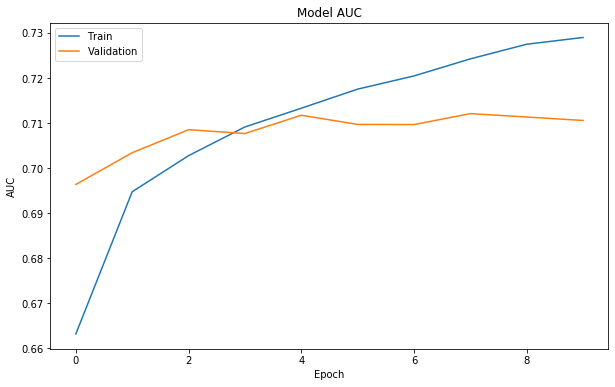

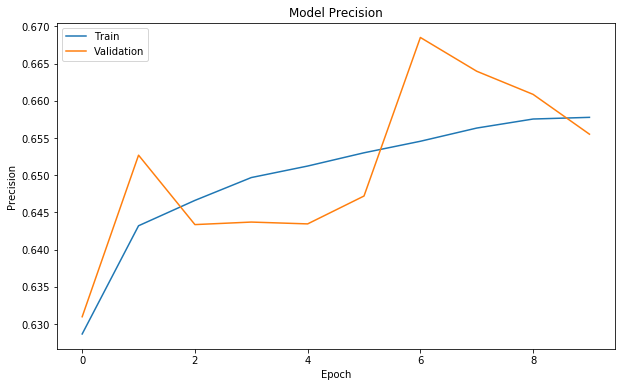

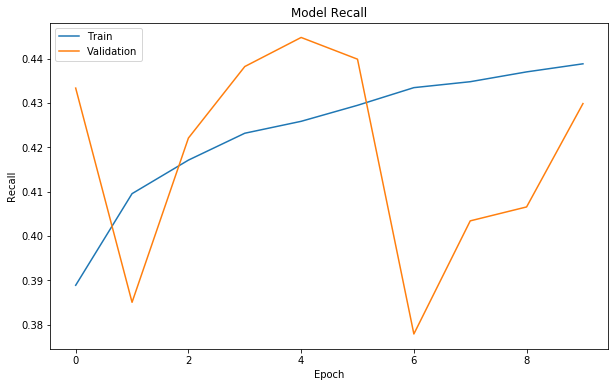

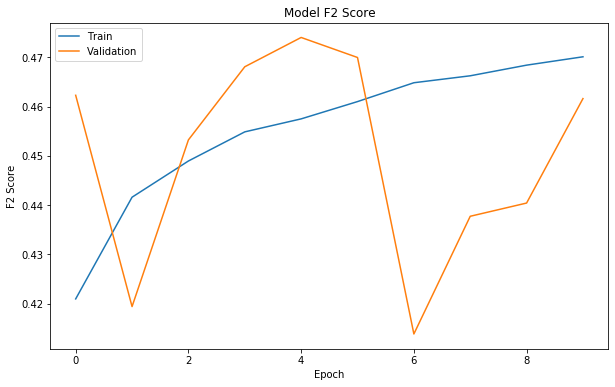

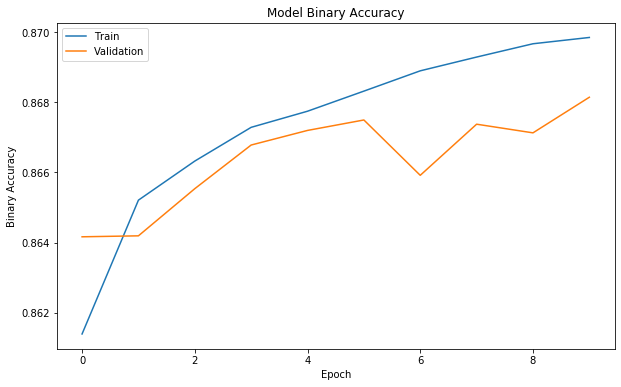

In [6]:
def print_or_plot_metric(metric_key, metric_name, figure_name):
    if len(history[metric_key]) == 1:
        print("Data for {m_name} only available for a single epoch. \nSkipping plot and printing data...".format(m_name=metric_name))
        print('Train {}: '.format(metric_name), history[metric_key])
        print('Validation {}: '.format(metric_name), history['val_'+metric_key])
        print()        
    else:
        plot_epoch_metric(metric_key, metric_name, figure_name)
        
def plot_epoch_metric(metric_key, metric_name, figure_name):
    figure(num=None, figsize=(10, 6))
    plt.plot(history[metric_key])
    if 'val_'+metric_key in history.keys():
        plt.plot(history['val_'+metric_key])
    plt.title(figure_name)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    if 'val_'+metric_key in history.keys():
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

for i, metric_key in enumerate(metric_keys):
    print_or_plot_metric(metric_key, metric_names[i], "Model "+metric_names[i])

## Plot training & validation loss values

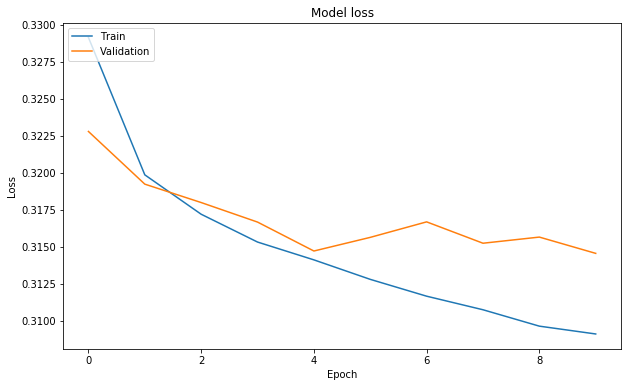

In [7]:
print_or_plot_metric("loss", "Loss", "Model loss")

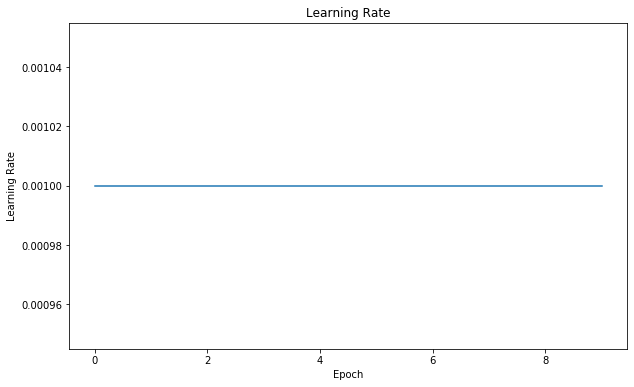

In [8]:
if "lr" in history.keys():
    plot_epoch_metric("lr", "Learning Rate", "Learning Rate")

## Classification Report

In [9]:
if 'classification_report' in data.keys() and data['classification_report']:
    print(data['classification_report'])

precision    recall  f1-score   support

                No Finding       0.08      0.01      0.01      4376
Enlarged Cardiomediastinum       0.00      0.00      0.00      2106
              Cardiomegaly       0.13      0.01      0.01      5373
              Lung Opacity       0.47      0.51      0.49     20760
               Lung Lesion       0.00      0.00      0.00      1760
                     Edema       0.23      0.11      0.15     10416
             Consolidation       0.00      0.00      0.00      2791
                 Pneumonia       0.00      0.00      0.00      1180
               Atelectasis       0.00      0.00      0.00      6532
              Pneumothorax       0.11      0.00      0.00      3669
          Pleural Effusion       0.39      0.33      0.35     16912
             Pleural Other       0.00      0.00      0.00       675
                  Fracture       0.00      0.00      0.00      1824
           Support Devices       0.53      0.55      0.54     22813

      

## Test Scores

In [10]:
if 'test' in data.keys() and data['test']:
    for score_name, score in data["test"].items():
        print('Test {}: '.format(score_name), score)



Test loss:  0.3134183883666992
Test AUC:  0.7099723815917969
Test Precision:  0.6531801223754883
Test Recall:  0.42758455872535706
Test F2Score:  0.45931196212768555
Test BinaryAccuracy:  0.8687735199928284


## Benchmark Details

In [11]:
pp = pprint.PrettyPrinter(indent=4)
if "benchmark" in data.keys():
    pp.pprint(data["benchmark"])

{   'batch_size': 128,
    'benchmark_name': 'Chexpert BCE E10 B128',
    'dataset_folder': 'data/chexpert/full',
    'dataset_name': 'chexpert_full',
    'dim': [256, 256],
    'drop_last': True,
    'epochs': 10,
    'label_columns': [   'No Finding',
                         'Enlarged Cardiomediastinum',
                         'Cardiomegaly',
                         'Lung Opacity',
                         'Lung Lesion',
                         'Edema',
                         'Consolidation',
                         'Pneumonia',
                         'Atelectasis',
                         'Pneumothorax',
                         'Pleural Effusion',
                         'Pleural Other',
                         'Fracture',
                         'Support Devices'],
    'loss': 'binary_crossentropy',
    'metrics': ['AUC', 'Precision', 'Recall', 'F2Score', 'BinaryAccuracy'],
    'models_dir': 'models',
    'n_channels': 3,
    'nan_replacement': 0,
    'optimizer': 'A

# Data Distribution

In [70]:
if 'benchmark' in data.keys() and 'split_seed' in data['benchmark']:
    benchmark = data['benchmark']

    dataset_path = Path(benchmark['dataset_folder'])
    train_labels = benchmark['train_labels'] if 'train_labels' in benchmark.keys() else 'train.csv'
    split_test_size =  benchmark['split_test_size'] if 'split_test_size' in benchmark.keys() else 0.2
    split_valid_size =  benchmark['split_valid_size'] if 'split_valid_size' in benchmark.keys() else 0.2
    split_group = benchmark['split_group'] if 'split_group' in benchmark.keys() else 'patient_id'
    split_seed = benchmark['split_seed']

    all_labels = pd.read_csv(dataset_path / train_labels)
    train_labels, test_labels = train_test_split(all_labels, test_size=split_test_size, group=split_group, seed=split_seed)
    train_labels, validation_labels = train_test_split(train_labels, test_size=split_valid_size, group=split_group, seed=split_seed)


In [71]:
from src.datasets.u_encoding import uencode

def get_distribution(labels):
    data = labels.fillna(benchmark['nan_replacement']).to_numpy()
    data = uencode(benchmark['u_enc'], data, unc_value=benchmark['unc_value'])
    data = pd.DataFrame(data, columns=labels.columns)

    labels = data[benchmark['label_columns']]

    d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Negative': [], 'Negative %': [],}
    for label in labels.columns:
        values = labels.groupby(label)
        d['Pathology'].append(label)

        positive = values.size()[1.0] if 1.0 in values.size() else 0
        positive_percent = positive / labels.shape[0] * 100
        d['Positive'].append(positive)
        d['Positive %'].append(round(positive_percent))

        negative = values.size()[-0.0] if -0.0 in values.size() else 0
        negative_percent = negative / labels.shape[0] * 100
        d['Negative'].append(negative)
        d['Negative %'].append(round(negative_percent))
    
    df = pd.DataFrame(d)
    df = df.set_index('Pathology')

    return df

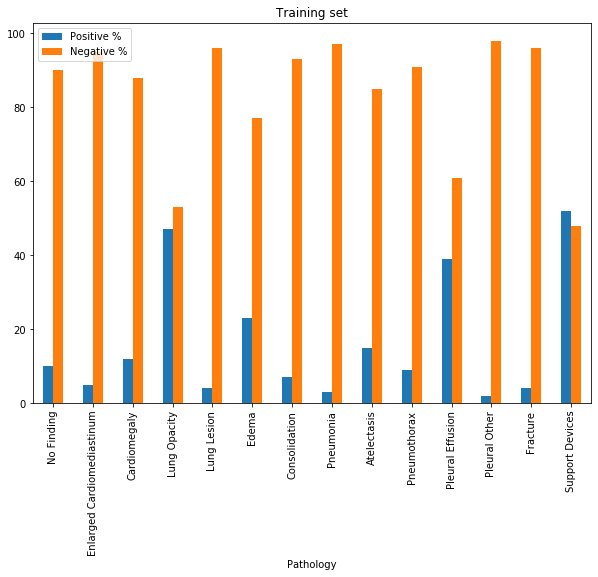

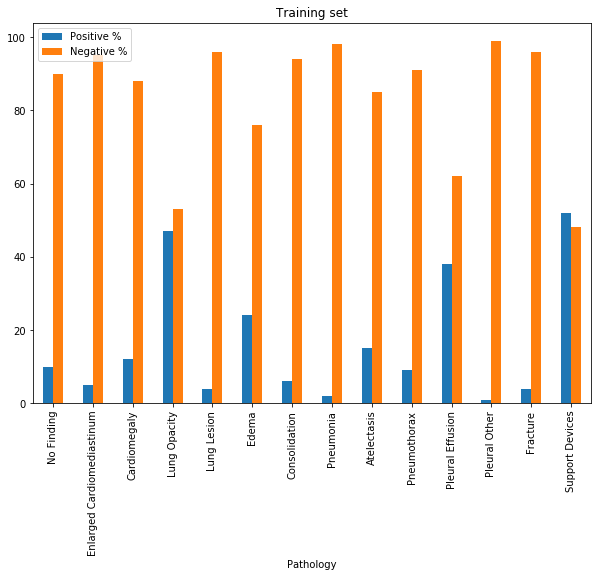

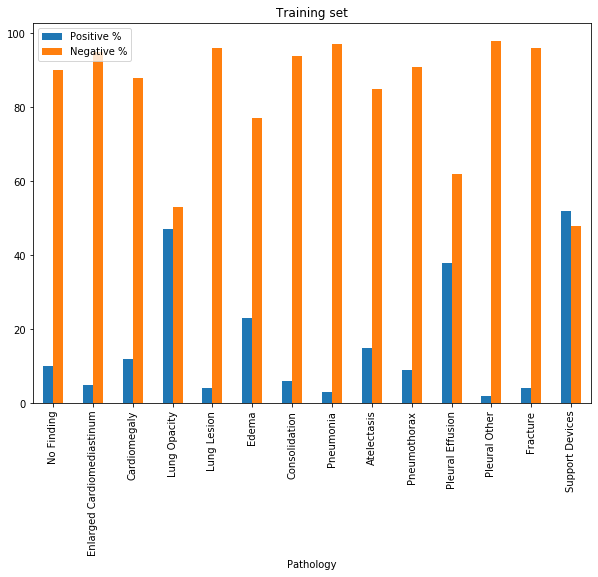

In [75]:
if 'benchmark' in data.keys() and 'split_seed' in data['benchmark']:
    train = get_distribution(train_labels)
    train.fillna(0)[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Training set")

    val = get_distribution(validation_labels)
    val.fillna(0)[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Training set")

    test = get_distribution(test_labels)
    test.fillna(0)[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Training set")